In [1]:
import numpy as np
import pandas as pd

import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.model_selection import LearningCurveDisplay

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import datasets
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

from sklearn import metrics

<h1><center>Validación de Modelos</center></h1>

<h2>Cross Validation (CV)</h2>

Uno de los problemas habituales que afrontamos cuando trabajamos con modelos de Machine Learning es el sesgo que se podría introducir en un modelo por la elección aleatoria de los conjuntos de testeo y entrenamiento. Podría suceder que se elija un conjunto de datos que produzca buenas métricas para el modelo pero que este sea solo un caso fortuito y que en realidad se tenga un modelo con bajo desempeño, esto se puede dar especialmente cuando los datos no están balanceados. Una de las principales estrategias para hacer frente a este problema es utilizar ***Cross Validation*** (CV). Existen múltiples técnicas de este tipo, la más común es conocida como *k-fold* CV y consiste en dividir el conjunto de entrenamiento (training set) en k partes, y luego utilizar cada una de estas  como conjunto de validación y el resto ($k-1$) como entrenamiento para el modelo, generandose así $k$ métricas (del mismo tipo), el promedio de estas será un mejor estimador del desempeño del modelo bajo prueba. 

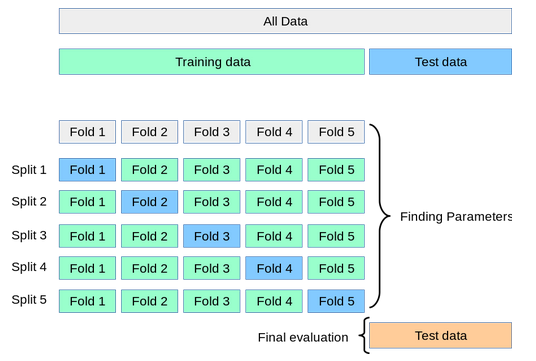

<br>
Imagen tomada de la <a src="https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation">documentación</a> de Sklearn.


En la imágen arriba el conjunto de entrenamiento fue dividido en $5$ subconjuntos y cada uno de ellos es utilizado en cada iteración como conjunto de validación.

Cuando un modelo es testeado con los mismos datos que fue entrenado se obtendrán excelentes métricas, pero estas no describen la realidad del modelo pues están prediciendo datos que ya han sido vistos por este, problema conocido como **overfiting**, un modelo que sólo puede entender los datos con los que fue entrenado. CV presenta una solución a este problema, pues siempre habrá un conjunto de datos que el modelo no está viendo y es este el que se utiliza como conjunto de validación. 

A continuación un ejemplo del uso de CV para el conjunto de datos que hemos venido trabajando.

In [2]:
# Datos
path = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv"

df = pd.read_csv(path)
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [3]:
df.columns

Index(['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'ENGINESIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUELTYPE', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS'],
      dtype='object')

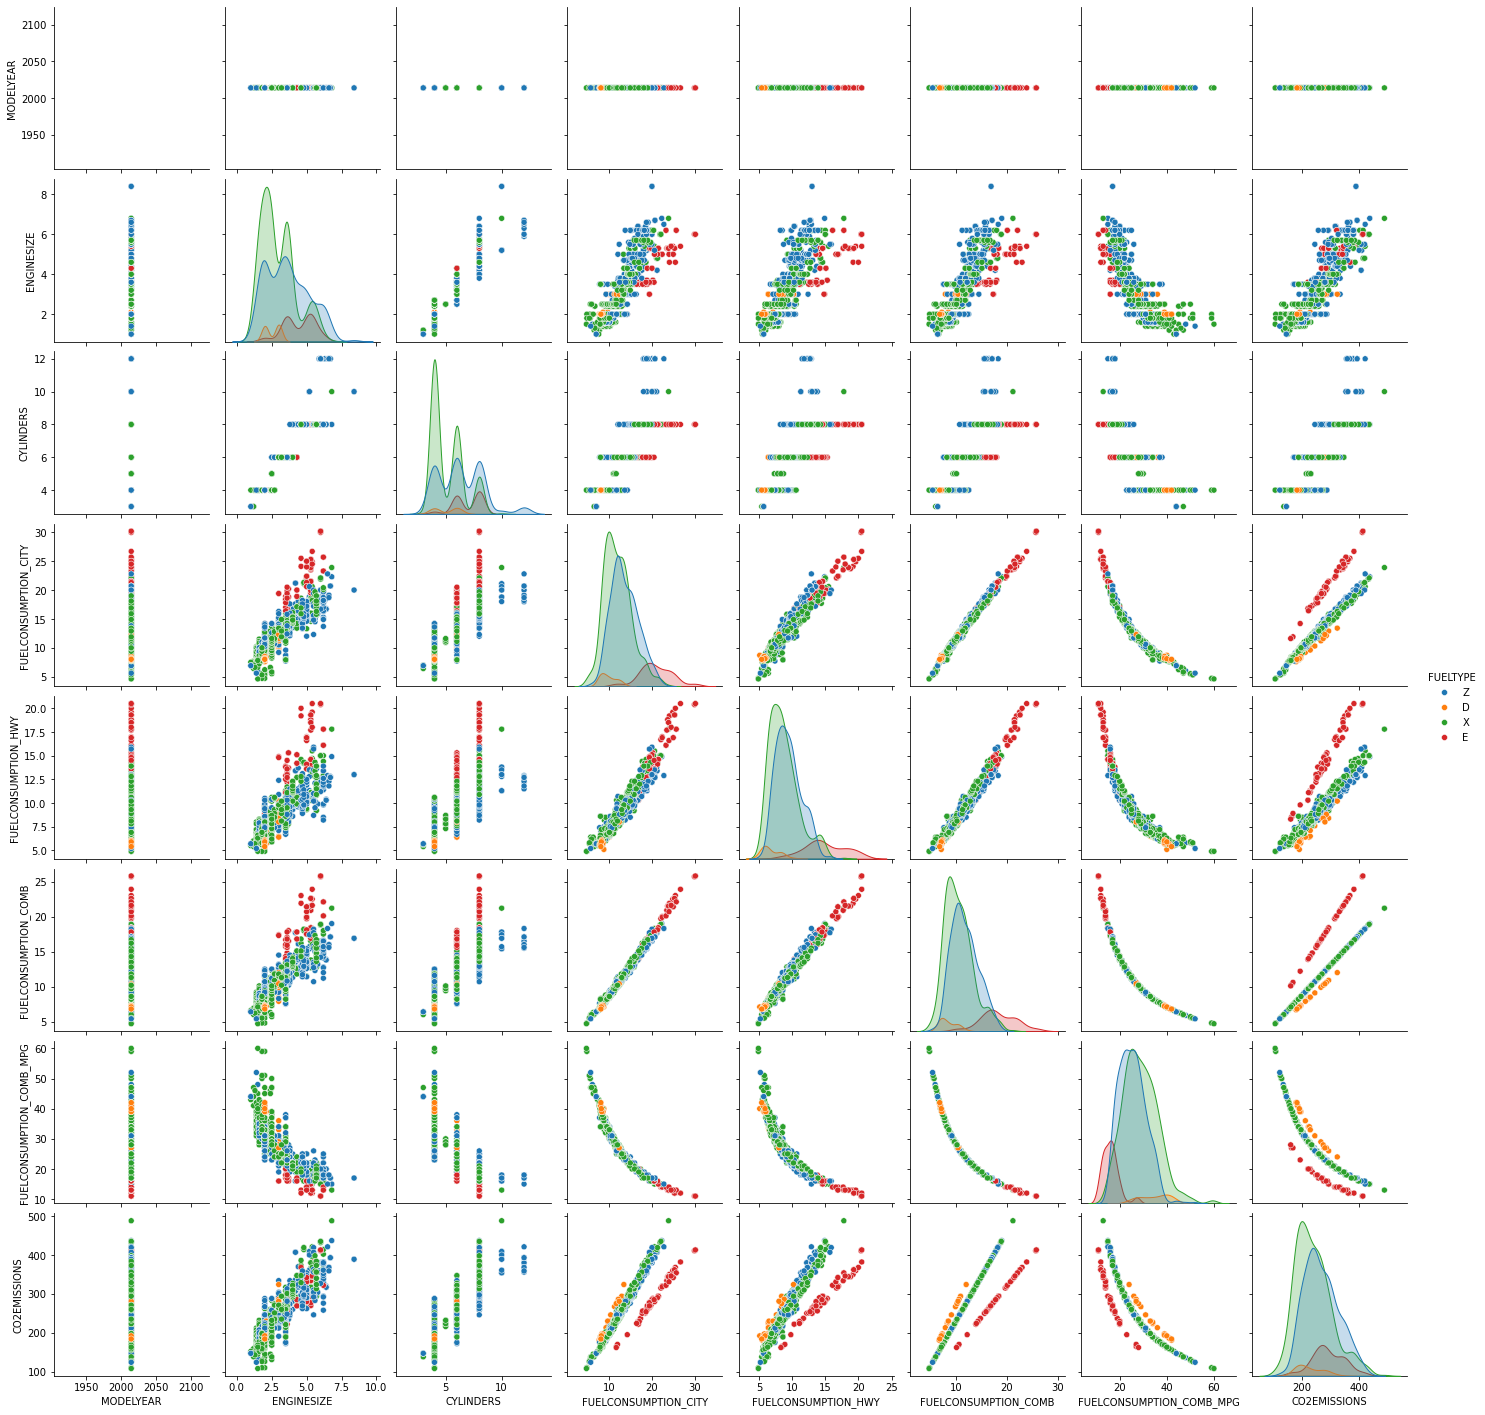

In [4]:
# Representacióon gráfica de la relación entre las features numéricas
hue="FUELTYPE"
sbn.pairplot(df, hue=hue)
plt.show()

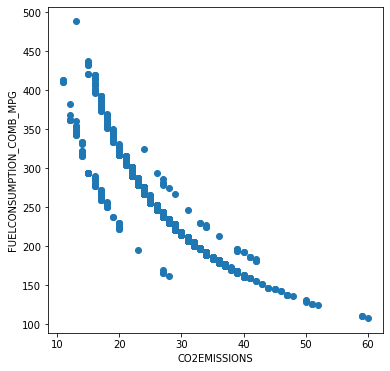

In [5]:
# Se propondrá un modelo polinómico para predecir la cantidad de emisiones de C02.
# 1. Escogemos nuestra variable predictora como FUELCONSUMPTION_COMB_MPG:
X = df[['FUELCONSUMPTION_COMB_MPG']]
y = df[['CO2EMISSIONS']]

fig = plt.figure(figsize=(6,6))
plt.scatter(x=X, y=y)
plt.xlabel("CO2EMISSIONS")
plt.ylabel("FUELCONSUMPTION_COMB_MPG")
plt.show()

Es siempre una buena práctica tener un conjunto de datos que se utilizarán para testeo al final del proceso de CV como se mostró en la anterior figura. 

In [6]:
# 2. Datos de entrenamiento y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2357)

<code>cross_val_score</code> permite realizar el proceso de CV con el fin de tener una mejor idea del desempeño del modelo. El modelo a utilizar es un ajuste polinómico de grado 2.

In [7]:
# 3. modelo
degree = 2
model_p2 = make_pipeline(PolynomialFeatures(degree),  LinearRegression())

# 4. Cross validation
CV_p2 = cross_val_score(estimator=model_p2, X=X_train, y=y_train, cv=5, scoring="r2")

print(f"R² CV testing = {CV_p2}\nmean={CV_p2.mean():.4f} std = {CV_p2.std():.4f}")

R² CV testing = [0.81497755 0.87199253 0.89705913 0.82734297 0.84532762]
mean=0.8513 std = 0.0298


El argumento *scoring* de <code>cross_val_score</code> también puede recibir una lista de las métricas con las cuales se quiere trabajar si es necesario. 

Ahora, una ves visto el desempeño del modelo con CV, procedemos a ver el verdadero desempeño del modelo realizando el entrenamiento con todos los datos y posteriormente calculando las metricas correspondientes.

In [8]:
# 5. Entrenamiento utilizando todos los datos
model_p2 = make_pipeline(PolynomialFeatures(degree),  LinearRegression())
model_p2.fit(X=X_train, y=y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [9]:
print(f"R2_training = {metrics.r2_score(y_pred=model_p2.predict(X_train),y_true=y_train)}")
print(f"R2_testing  = {metrics.r2_score(y_pred=model_p2.predict(X_test), y_true=y_test)}")

R2_training = 0.8522220212639192
R2_testing  = 0.8508347693671509


Estos resultados muestran poca discrepancia entre las métricas obtenidas con CV y los datos completos, lo cual es un resultado esperado. A continuación se presentará una de las principales utilidades del proceso de CV; la determinación de los *hiperparámetros* del modelo.

<h2>Sesgo vs Varianza</h2>

Antes de aplicar el método de CV es necesario dejar muy en claro cómo se determina que un modelo sea mejor que otro. La respuesta a esto viene de encontrar un punto óptimo entre sesgo y varianza. Un modelo que es incapaz de predecir incluso los datos con los que fue entrenado es un modelo sesgado (**underfiting**), sus métricas tanto de entrenamiento como de testeo son malas pues el modelo es incapaz de comprender el verdadero comportamiento de los datos. Por el otro lado, un modelo que tiene excelentes métricas de entrenamiento pero cuyas métricas de testeo son malas es un modelo con alta varianza (**overfiting**), es un modelo que se ha pegado tanto a sus datos de entrenamiento que no puede realizar ninguna predicción más allá de los datos que conoce. Claramente ninguno de los dos extremos es deseado, se busca entonces un punto donde tanto sesgo como varianza sean óptimos. 

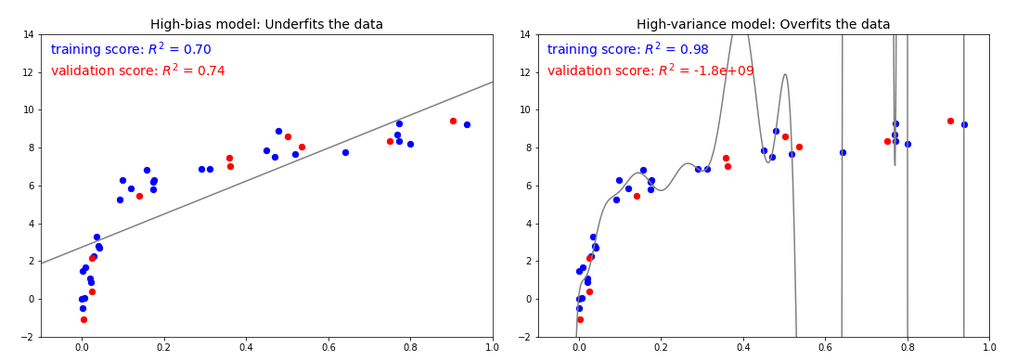


[link imagen](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-bias-variance-2.png?raw=true">)

Como se puede ver, el modelo con alto sesgo (bias) es intríncicamente incapaz de entender el comportamiento de los datos pues su naturaleza es de mayor complejidad que el modelo. Por otro lado, el modelo con alta varianza sólo puede entender los datos con los cuales fue entrenado (puntos en azul), no es capaz de realizar predicciones eficaces sobre el conjunto de testeo (puntos rojos). Se dice que el modelo tiene alta varianza pues al analizar las métricas del conjunto de testeo (por ejemplo un MSE) como los resultados obtenidos se alejan tanto de los esperados entonces la varianza del modelo explota (la suma cuadrática de los residuales del modelo crece muy rápidamente). 

Siendo así, el mejor modelo será aquel que presente un equilibrio entre sesgo y varianza. Si se grafica los valores obtenidos para las métricas de testeo y entrenamiento de un modelo, se esperaría que la curva de entrenamiento aumente de manera asintótica, indicando esto que el modelo, por más complejidad que tenga, no será capaz de aprender más de los datos, por otro lado, la curva de testeo deberá encontrar un valor máximo a partir del cual comenzará a descender. Este punto, donde comienza a disminuir el valor de la métrica de testeo, será el punto de equilibrio buscado y es este el que proporciona los mejores hiperparámetros para el modelo. 

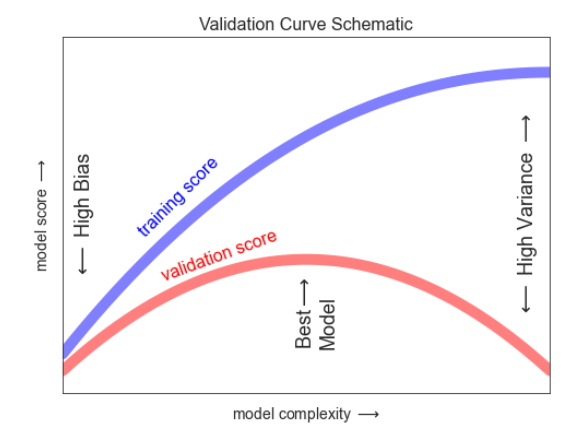


[link imagen](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.03-validation-curve.png?raw=true">)

<h3>Curvas de Validación</h3>

Una de las técnicas que se pueden utilizar para analizar el comportamiento del sesgo y la varianza del modelo es las *curvas de validación*. Con estas se muestra la influencia de un *único hiperparámetro* sobre el score. Es importante resaltar que este método sólo sería aplicable para analizar el comportamineto de un único hiperparámetro, en caso que se quiera analizar más de uno es recomendable utilizar GridSearch, además de que si son muchos los hiperparámetros a analizar la representación gráfica se vuelve mucho más compleja (con 2 hiperparámetros se necesitaría un gráfico 3D). 

La herramienta <code>validation_curve</code> de Sklearn realiza un proceso de CV para un conjunto de valores de un hiperparámetro y retorna las métricas de entrenamiento y testeo que son necesarias para costruir las curvas de validación que permitirán encontrar los mejores hiperparámetros. 

Continuando con el modelo polinómico anteriormente planteado, una duda tiene sentido ¿Cuál es el grado del polinomio que proporciona las mejores métricas? Utilicemos <code>validation_curve</code> para determinar esto. 

In [10]:
# Modelo
def model_pn(degree=2):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Primero definimos el conjunto de grados del polinomio que se utilizarán.
degs = np.arange(1, 15, 1)

# Aplicamos validation_curve
training_score, validation_score = validation_curve(model_pn(), 
                                                    X=X_train, y=y_train,
                                                    cv=5, scoring="r2", 
                                                    param_name="polynomialfeatures__degree", param_range=degs)
training_score

array([[0.82645333, 0.81148981, 0.81168293, 0.82919294, 0.81660359],
       [0.86065297, 0.84661086, 0.84169813, 0.85889139, 0.8537848 ],
       [0.86112299, 0.84691417, 0.84240557, 0.85983238, 0.85411446],
       [0.86639745, 0.85167908, 0.84716609, 0.86597019, 0.85861031],
       [0.86773941, 0.85260178, 0.84824716, 0.8677144 , 0.85991649],
       [0.86803824, 0.85302619, 0.84878465, 0.86813631, 0.86019527],
       [0.86859731, 0.85401272, 0.84960247, 0.86934259, 0.86075087],
       [0.86823048, 0.85333443, 0.84905699, 0.86856599, 0.86039098],
       [0.86821203, 0.85321558, 0.84892029, 0.86847319, 0.86036604],
       [0.86823683, 0.85327872, 0.8489539 , 0.86855285, 0.86039692],
       [0.86821129, 0.85327932, 0.84895544, 0.86847992, 0.86038207],
       [0.86826058, 0.85330561, 0.84896974, 0.86844405, 0.86041733],
       [0.8681358 , 0.85312393, 0.84879901, 0.86862245, 0.86023144],
       [0.86685792, 0.85172728, 0.84757802, 0.86848244, 0.85888471]])

In [11]:
validation_score

array([[ 0.78499087,  0.84564975,  0.85048969,  0.78147635,  0.82847745],
       [ 0.81497755,  0.87199253,  0.89705913,  0.82734297,  0.84532762],
       [ 0.81552839,  0.87304565,  0.8966493 ,  0.82427354,  0.84637916],
       [ 0.82012354,  0.8794658 ,  0.9035998 ,  0.82514108,  0.85408958],
       [ 0.82136801,  0.88228811,  0.90591273,  0.82686485,  0.85555436],
       [ 0.82206597,  0.88257583,  0.90557621,  0.8268795 ,  0.85631514],
       [ 0.82379902,  0.88278822,  0.90645052,  0.82546085,  0.85800518],
       [ 0.8226269 ,  0.88273501,  0.90583238,  0.82581669,  0.856838  ],
       [ 0.82242638,  0.88288283,  0.90609026,  0.82663455,  0.8566674 ],
       [ 0.82258144,  0.88290016,  0.90628121,  0.82565329,  0.85678163],
       [ 0.82257518,  0.88282248,  0.90621072,  0.82077391,  0.85672976],
       [ 0.82256196,  0.88294216,  0.9063778 ,  0.82573524,  0.85681577],
       [ 0.82244944,  0.88315352,  0.90661798,  0.77825904,  0.85709171],
       [ 0.82122798,  0.88267792,  0.9

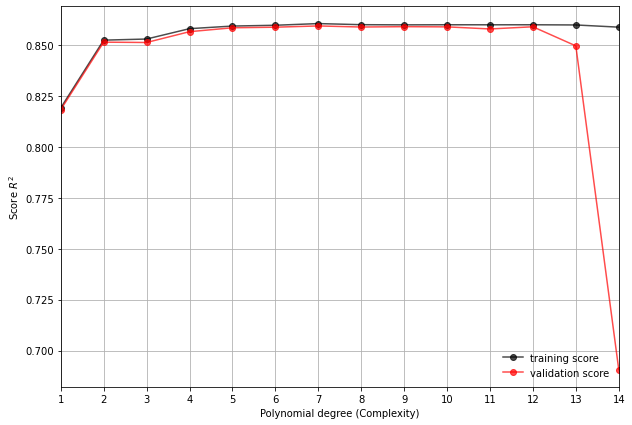

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(degs, training_score.mean(axis=1),   label="training score",   c="k",   marker="o", alpha=0.7)
ax.plot(degs, validation_score.mean(axis=1), label="validation score", c="red", marker="o", alpha=0.7)

ax.set_xlim(min(degs), max(degs))
ax.set_xlabel("Polynomial degree (Complexity)")
ax.set_ylabel("Score $R^2$")
plt.xticks(ticks=degs, labels=degs)
ax.legend(frameon=False, loc="lower right")
ax.grid()
plt.show()

In [13]:
degs[np.where(validation_score.mean(axis=1)==max(validation_score.mean(axis=1)))]

array([7])

Según el resultado obtenido el polinomio de grado 7, es el que presenta el mejor valor del score de validación, pero esto no implica que sea este el que se deba elegir. Todos los polinomios de grados inferiores a 7 y mayores a 2 también presentan un buen score y no son computacionalmente tan complejos, por esto bastaría con un polinomio de grado 4 para obtener un buen modelo. Una discución sobre este último punto se presenta en el <a src="https://stats.stackexchange.com/questions/310953/doubt-about-k-fold-crossvalidation?noredirect=1&lq=1">enlace</a>. 

Otra alternativa para graficar la curva de validación es utilizar <code>ValidationCurveDisplay</code> de Sklearn. 

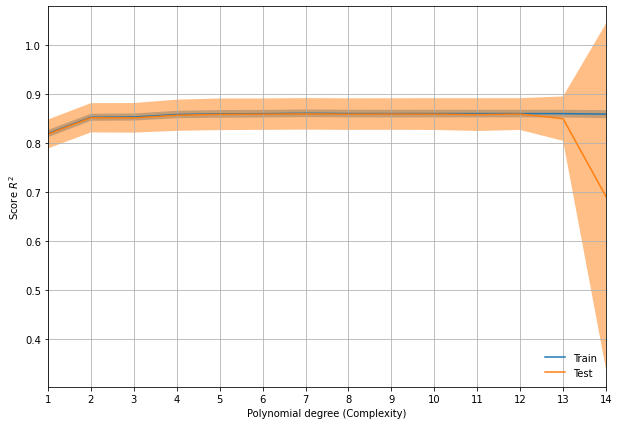

In [14]:
fig, ax = plt.subplots(figsize=(10, 7))

ValidationCurveDisplay.from_estimator(estimator=model_pn(degree=2),
                                      X=X_train, y=y_train,
                                      param_name='polynomialfeatures__degree', param_range=degs, 
                                      ax=ax)

ax.set_xlim(min(degs), max(degs))
ax.set_xlabel("Polynomial degree (Complexity)")
ax.set_ylabel("Score $R^2$")
plt.xticks(ticks=degs, labels=degs)
ax.legend(frameon=False, loc="lower right")
ax.grid()
plt.show()

<h3>Curvas de aprendizaje</h3>

El desempeño del modelo no sólo dependerá de los valores de los hiperparámetros, otro aspecto que se debe tener muy presente es el tamaño del conjunto de entrenamiento. Adherir más datos de entrenamiento no necesariamente generará un mejor modelo. Una **curva de aprendizaje** muestra la variación en el score respecto al tamaño del conjunto de entrenamiento.

<code>learning_curve</code> nos ayuda a generar los datos necesarios para la contrucción de las curvas de aprendizaje retornando los tamaños de los subconjuntos de entrenamiento y los scores tanto de entrenamiento como de validación para el proceso de CV realizado para cada subconjunto de entrenamiento.

<code>learning_curve</code> empieza por dividir el conjunto de datos en $k=cv$ partes de aproximadamente igual tamaño para realizar el procedimiento de CV. Luego de esto crea cada uno de los subconjuntos de entrenamiento del tamaño indicado por los valores en el argumento *train_sizes* de <code>learning_curve</code> para entrenar el modelo (este subconjunto es tomado de las $k-1$ particiones restantes de los datos), se calcula la métrica deseada de entrenamiento y con la partición restante del proceso de CV se calculan las métricas de validación para ese subconjunto de entrenamiento. 

Con base a lo anterior existe un tamaño límite para los subconjuntos de entrenamiento que estaría dado por la cantidad de datos presentes en las $k-1$ particiones de los datos. Esto es:

\begin{equation}
    train\_sizes = \left(1, \ TOTAL\_DATOS\times\left(1-\frac{1}{k}\right) \right]
\end{equation}

Es aconsejable el uso de <code>learning_curve</code> con los datos de entrenamiento y no con el total de datos para evitar overfiting (al igual que con <code>validation_curve</code>).

In [15]:
# Tamaño del conjunto de entrenamiento (porcentaje)
#training_sizes = np.linspace(0.01, 1, 20)
cv = 5
training_sizes = np.linspace(2, int(X_train.shape[0]*(1-1/cv)), 20, dtype=int)
print(f"Tamaños de entrenamiento: {training_sizes}")

N, training_score, val_score = learning_curve(
                                            estimator=model_pn(degree=4),
                                            X=X_train,
                                            y=y_train,
                                            train_sizes=training_sizes,
                                            cv=cv,
                                            scoring="r2",
                                            shuffle=True, random_state=42)

print(f"Tamaños de entrenamiento: {N}")

Tamaños de entrenamiento: [  2  37  73 109 145 180 216 252 288 324 359 395 431 467 503 538 574 610
 646 682]
Tamaños de entrenamiento: [  2  37  73 109 145 180 216 252 288 324 359 395 431 467 503 538 574 610
 646 682]


In [16]:
#print(training_score, "\n\n", val_score)

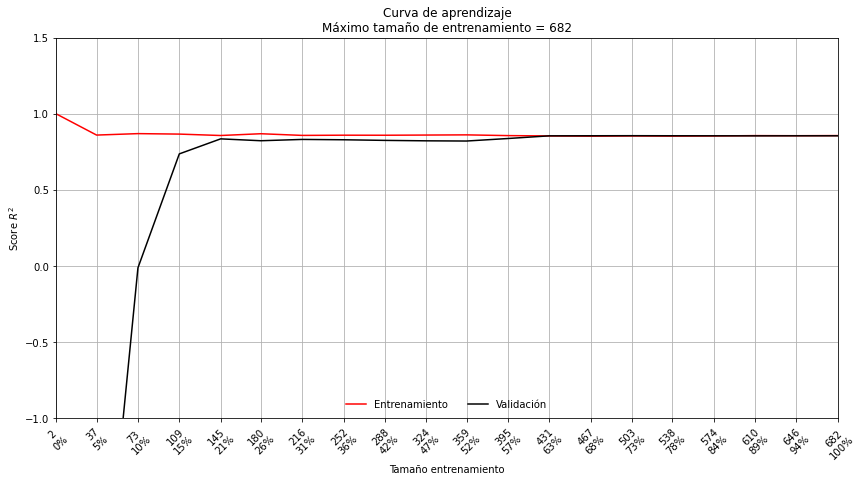

In [17]:
fig, ax = plt.subplots(figsize=(14,7))

ax.plot(N, training_score.mean(axis=1), label="Entrenamiento", color="red")
ax.plot(N, val_score.mean(axis=1),      label="Validación",    color="k")

ax.set_xticks(N)
ax.set_xticklabels([f"{i}\n{int(i/N[-1]*100)}%" for i in N], rotation=45)
ax.set_ylim(-1, 1.5)
ax.set_xlim(min(N), max(N))

ax.set_xlabel("Tamaño entrenamiento")
ax.set_ylabel("Score $R^2$")
ax.set_title(f"Curva de aprendizaje\nMáximo tamaño de entrenamiento = {N[-1]}")

ax.grid()
ax.legend(frameon=False, loc="lower center", ncol=2)
plt.show()

Al igual que con <code>validation_curve</code>, la herramienta <code>LearningCurveDisplay</code> de Sklearn permite graficar la curva de aprendizaje.

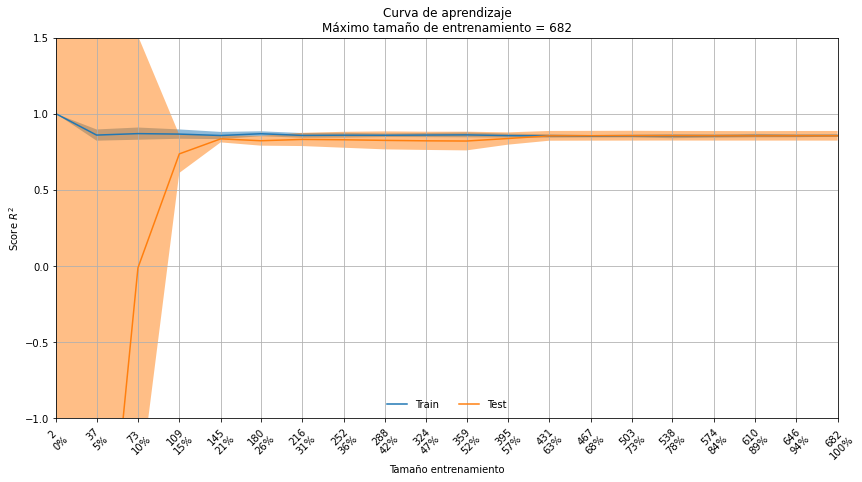

In [18]:
fig, ax = plt.subplots(figsize=(14,7))
LearningCurveDisplay.from_estimator(
                                estimator=model_pn(degree=4), 
                                X=X_train, 
                                y=y_train, 
                                train_sizes=training_sizes, 
                                scoring="r2",
                                cv=cv,
                                shuffle=True, random_state=42,
                                ax=ax)

ax.set_xticks(N)
ax.set_xticklabels([f"{i}\n{int(i/N[-1]*100)}%" for i in N], rotation=45)
ax.set_ylim(-1, 1.5)
ax.set_xlim(min(N), max(N))

ax.set_xlabel("Tamaño entrenamiento")
ax.set_ylabel("Score $R^2$")
ax.set_title(f"Curva de aprendizaje\nMáximo tamaño de entrenamiento = {N[-1]}")

ax.grid()
ax.legend(frameon=False, loc="lower center", ncol=2)
plt.show()

El resultado obtenido da cuenta de la capacidad de aprendizaje del modelo a partir del tamaño del conjunto de entrenamiento. Acá se puede observar que, para este modelo, un conjunto de entrenamiento mayor a unos 145 datos no repercutirá considerablemente en la mejora de las métricas de entrenamiento y validación. Es habitual escuchar la sentencia que dice que un mayor conjunto de datos de entrenamiento siempre será mejor, pero antes de realizar gran ezfuerzo en la búsqueda de datos es menester primero examinar si el modelo en efecto podría tener ganancias significativas al aumentarlos.  

A continuación se examinarán las curvas de aprendizaje para diferentes grados de complejidad de un modelo polinómico.

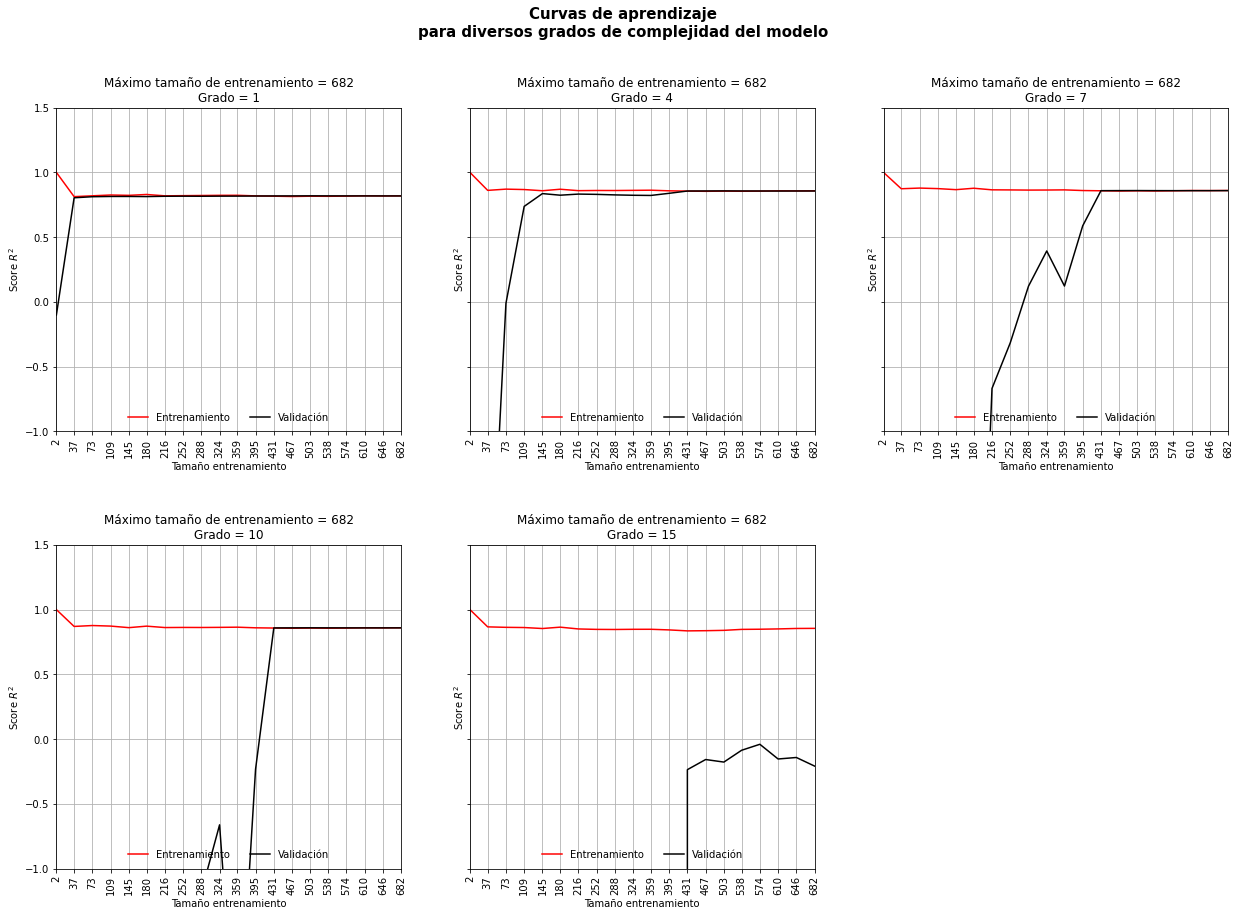

In [19]:
degs  = [1, 4, 7, 10, 15]
ncols = 3
nrows = len(degs)//ncols + (1 if len(degs)%ncols!=0 else 0)
locs  = [(nr, nc) for nr in range(nrows) for nc in range(ncols)]

cv = 5
training_sizes = np.linspace(2, int(X_train.shape[0]*(1-1/cv)), 20, dtype=int)

fig, ax = plt.subplots(figsize=(7*ncols, 7*nrows), ncols=ncols, nrows=nrows, sharey=True)

for i in range(ncols*nrows):
    if i<len(degs):
        N, train_score, val_score = learning_curve(
                                            estimator=model_pn(degree=degs[i]),
                                            X=X_train,
                                            y=y_train,
                                            train_sizes=training_sizes,
                                            cv=cv,
                                            scoring="r2",
                                            shuffle=True, random_state=42)
        
        ax[locs[i]].plot(N, train_score.mean(axis=1), label="Entrenamiento", color="red")
        ax[locs[i]].plot(N, val_score.mean(axis=1),   label="Validación",    color="k")
        
        ax[locs[i]].set_xticks(N)
        ax[locs[i]].set_xticklabels([f"{j}" for j in N], rotation=90)
        ax[locs[i]].set_ylim(-1, 1.5)
        ax[locs[i]].set_xlim(min(N), max(N))
        
        ax[locs[i]].set_xlabel("Tamaño entrenamiento")
        ax[locs[i]].set_ylabel("Score $R^2$")
        ax[locs[i]].set_title(f"Máximo tamaño de entrenamiento = {N[-1]}\nGrado = {degs[i]}")
        
        ax[locs[i]].grid()
        ax[locs[i]].legend(frameon=False, loc="lower center", ncol=2)
        
    else:
        ax[locs[i]].set_axis_off()

#plt.tight_layout()
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 15}
fig.subplots_adjust(hspace=0.35)
fig.suptitle("Curvas de aprendizaje\npara diversos grados de complejidad del modelo", **font)
plt.show()

Como se puede observar, modelos más complejos requieren de mayor cantidad de datos para ser entrenados de manera correcta.

<h2>Ajuste de hiperparámetros: Gridsearch</h2>

Como es sabido los modelos de Machine Learning no realizan un ajuste a sus hiperparámetros durante la etapa de entrenamiento, por esto se conocen como tal. **Siempre** es necesario realizar un ajuste a los hiperparámetros de un modelo de manera que sean los mejores según alguna regla de decisión. Se puede elegir aquel modelo que maximiza una única métrica, pero es posible, y habitualmente necesario, decidir basados en múltiples métricas y otros criterios para un mismo modelo, como es habitual en problemas de clasificación. Este proceso se realiza considerando las posibles combinaciones de los hiperparámetros del modelo y Sklearn ofrece dos opciones para llevarlo a cabo, ambas basadas en el proceso de CV.

<ul>
    <li><code>GridSearchCV</code>. Este método considera todas las posibles combinaciones de
    los hiperparámetros. Para cada una de ellas entrena el modelo siguiendo un proceso de CV
    y ofrece luego las metricas indicadas. El parámetro <code>refit</code> permite personalizar 
    el criterio de elección del mejor modelo.</li> 
    <li><code>RandomizedSearchCV</code>. Los valores a utilizar de cada parámetro provienen de
    la función distribución que se asume siga cada uno de ellos. El argumento <code>n_iter</code> determina el 
    número de combinaciones a realizar, luego de esto se realiza un proceso de CV al igual que con 
    <code>GridSearchCV</code>. El método también permite elegir los posibles valores de un hiperparámetro
    a partir de una lista con los valores discretos.</li>
</ul>

En la [documentación](https://scikit-learn.org/stable/modules/grid_search.html#grid-search-tips) de Sklearn se puede encontrar una guía bastante amplia del uso de estos métodos. A continuación algunos ejemplos.

<h3><code>GridSearchCV</code></h3>

A continuación varios ejemplos del uso de <code>GridSearchCV</code>. Se comenzará con la aplicación del método al modelo polinomial y luego para un modelo de clasificación. Se verá cómo se puede aplicar una estrategia de elección más elaborada a la que por defecto viene con <code>GridSearchCV</code> (mejor score) usando el parámetro <code>refit</code>.

<h4><code>GridSearchCV</code> para un modelo de regresión lineal. </h4>

In [20]:
# Métrica a utilizar
scores = 'r2'

# Grid
param_grid_pn  = {"polynomialfeatures__degree":np.linspace(1, 12, 12, dtype=int)}

grid_search_pn = GridSearchCV(
                    estimator=model_pn(),
                    param_grid=param_grid_pn, 
                    scoring=scores,
                    cv=5, 
                    return_train_score=True)


# Entrenamiento
grid_search_pn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])},
             return_train_score=True, scoring='r2')

In [21]:
type(grid_search_pn)

sklearn.model_selection._search.GridSearchCV

El objeto *GridSearchCV* tendrá almacenada toda la información sobre las métricas, tiempos, parámetros utilizados y más durante el proceso de CV. Se utiliza el método <code>cv_results_</code> que retorna un diccionario para verlas.

In [22]:
grid_search_pn.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_polynomialfeatures__degree', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [23]:
# Alguna información del proceso realizado
for mean_train_score, std_train_score, mean_test_score, std_test_score, mean_score_time, params in zip(
    grid_search_pn.cv_results_["mean_train_score"],
    grid_search_pn.cv_results_["std_train_score"],
    grid_search_pn.cv_results_["mean_test_score"],
    grid_search_pn.cv_results_["std_test_score"],
    grid_search_pn.cv_results_["mean_score_time"],
    grid_search_pn.cv_results_["params"]):
    
    print(f"{scores}_train = {mean_train_score:.4f} ± {std_train_score:.4f} ",
          f"{scores}_test = {mean_test_score:.4f} ± {std_test_score:.4f} ",
          f"time_score = {mean_score_time:.5f} segs ",
          f"{list(params.keys())[0].split('_')[2]} = {list(params.values())[0]}")

r2_train = 0.8191 ± 0.0074  r2_test = 0.8182 ± 0.0295  time_score = 0.00323 segs  degree = 1
r2_train = 0.8523 ± 0.0072  r2_test = 0.8513 ± 0.0298  time_score = 0.00261 segs  degree = 2
r2_train = 0.8529 ± 0.0073  r2_test = 0.8512 ± 0.0302  time_score = 0.00281 segs  degree = 3
r2_train = 0.8580 ± 0.0076  r2_test = 0.8565 ± 0.0318  time_score = 0.00291 segs  degree = 4
r2_train = 0.8592 ± 0.0079  r2_test = 0.8584 ± 0.0323  time_score = 0.00253 segs  degree = 5
r2_train = 0.8596 ± 0.0078  r2_test = 0.8587 ± 0.0320  time_score = 0.00254 segs  degree = 6
r2_train = 0.8605 ± 0.0078  r2_test = 0.8593 ± 0.0322  time_score = 0.00262 segs  degree = 7
r2_train = 0.8599 ± 0.0078  r2_test = 0.8588 ± 0.0322  time_score = 0.00250 segs  degree = 8
r2_train = 0.8598 ± 0.0078  r2_test = 0.8589 ± 0.0322  time_score = 0.00266 segs  degree = 9
r2_train = 0.8599 ± 0.0079  r2_test = 0.8588 ± 0.0324  time_score = 0.00251 segs  degree = 10
r2_train = 0.8599 ± 0.0078  r2_test = 0.8578 ± 0.0334  time_score = 0

In [24]:
# El mejor modelo obtenido
print(f"Mejor modelo: {grid_search_pn.best_params_}",
      f"\nScore = {grid_search_pn.best_score_}")

Mejor modelo: {'polynomialfeatures__degree': 7} 
Score = 0.8593007592039955


Una vez se ha elegido el mejor modelo de acuerdo a la estrategia seleccionada, este se puede evaluar en el conjunto de testeo dejado por fuera del proceso de selección pues el objeto *GridSearchCV* ha sido entrenado con todos los datos de entrenamiento luego de la selección. 

In [25]:
metrics.r2_score(y_true=y_test,
                 y_pred=grid_search_pn.predict(X=X_test))

0.8686369057013414

**Nota:** Aunque se han mostrado las estadísticas obtenidas durante el proceso de elección, estas NO son representativas estadísticamente hablando para el modelo pues provienen de un proceso de CV y, como se verá en la sección en que se hablará sobre el **bootstrapping**, no son aptas para tal fin. Estas solo nos dan una idea de las métricas obtenidas en cada partición de CV y qué tan uniformes son. Siempre se debería de esperar una baja desviación de la media para ellas. 

In [26]:
# Scores de testeo para cada conjunto de CV
cv_scores_test = []
for i in range(grid_search_pn.cv):
    cv_scores_test.append(grid_search_pn.cv_results_['split'+str(i)+'_test_score'])
    
cv_scores_test = np.array(cv_scores_test)

In [27]:
# Métricas de los conjuntos para cada modelo (calculadas por nosotros)
cv_scores_test.mean(axis=0), cv_scores_test.std(axis=0)

(array([0.81821682, 0.85133996, 0.85117521, 0.85648396, 0.85839761,
        0.85868253, 0.85930076, 0.8587698 , 0.85894028, 0.85883954,
        0.85782241, 0.85888659]),
 array([0.02950664, 0.02983622, 0.03021128, 0.03180647, 0.03225533,
        0.03202411, 0.03219302, 0.032203  , 0.03218216, 0.0324032 ,
        0.03341432, 0.03242488]))

In [28]:
# Métricas de los conjuntos para cada modelo (entregadas por gridsearch)
grid_search_pn.cv_results_["mean_test_score"], grid_search_pn.cv_results_["std_test_score"]

(array([0.81821682, 0.85133996, 0.85117521, 0.85648396, 0.85839761,
        0.85868253, 0.85930076, 0.8587698 , 0.85894028, 0.85883954,
        0.85782241, 0.85888659]),
 array([0.02950664, 0.02983622, 0.03021128, 0.03180647, 0.03225533,
        0.03202411, 0.03219302, 0.032203  , 0.03218216, 0.0324032 ,
        0.03341432, 0.03242488]))

<h4><code>GridSearchCV</code> para un modelo de clasificación.</h4>

A continuación se aplica <code>GridSearchCV</code> para un modelo de clasificación usando los datos de cáncer de mama de <code>sklearn.datasets</code> y un modelo de SVM.

In [29]:
# Datos
cancer = datasets.load_breast_cancer()
df_cancer = pd.DataFrame(
                    np.c_[cancer['data'], cancer['target']],
                    columns= np.append(cancer['feature_names'], ['target']))

df_cancer["target"] = df_cancer["target"].astype(int)
df_cancer

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [30]:
# Valores nulos
df_cancer.isna().sum().sum()

0

In [31]:
# Targets y counts
for t in df_cancer["target"].unique():
    print(f"{t}: {cancer.target_names[t]:>10} -> {df_cancer.target.value_counts()[t]}")

0:  malignant -> 212
1:     benign -> 357


In [32]:
# Preparando los datos para el modelo
X = df_cancer.drop("target", axis=1)
y = df_cancer["target"]

X.shape, y.shape

((569, 30), (569,))

La grid que se creará examinará principalmente dos modelos, ambos en una misma lista y cada uno representado por un diccionario. El primero será una máquina de soporte vectorial con un kernel RBF (no lineal) y el otro será con un kernel lineal. 

In [34]:
# Score a utilizar
score = "matthews_corrcoef"

# Grid
param_grid_svm = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
             ]

grid_search_svm = GridSearchCV(
                    estimator=SVC(),
                    param_grid=param_grid_svm, 
                    scoring=score,
                    return_train_score=False,
                    cv=5)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# fit
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             scoring='matthews_corrcoef')

In [35]:
# Conjuntos de parámetros utilizados
grid_search_svm.cv_results_["params"]

[{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 1, 'kernel': 'linear'},
 {'C': 10, 'kernel': 'linear'},
 {'C': 100, 'kernel': 'linear'},
 {'C': 1000, 'kernel': 'linear'}]

In [36]:
# El mejor modelo obtenido
print(f"Mejor modelo: {grid_search_svm.best_params_}",
      f"\nScore = {grid_search_svm.best_score_}")

Mejor modelo: {'C': 10, 'kernel': 'linear'} 
Score = 0.9199288345377765


In [43]:
# mejores modelos en orden
model_name = []
for i in range(len(grid_search_svm.cv_results_["params"])):
    aux_str = "" 
    for key, value in zip(
        grid_search_svm.cv_results_["params"][i].keys(),
        grid_search_svm.cv_results_["params"][i].values()):
        aux_str += key+":"+str(value)+" "
    model_name.append(aux_str)
    
pd.DataFrame({"Model":model_name,
              "Rango":grid_search_svm.cv_results_["rank_test_score"],
              "Score":grid_search_svm.cv_results_["mean_test_score"]})\
            .set_index("Model")\
            .sort_values(by="Rango")

,Rango,Score
Model,,
C:10 kernel:linear,1,0.919929
C:1000 kernel:linear,2,0.913391
C:1 kernel:linear,3,0.904987
C:100 kernel:linear,4,0.904616
C:1 gamma:0.0001 kernel:rbf,5,0.846271
C:10 gamma:0.0001 kernel:rbf,6,0.832571
C:100 gamma:0.0001 kernel:rbf,7,0.828236
C:1 gamma:0.001 kernel:rbf,8,0.826336
C:1000 gamma:0.0001 kernel:rbf,9,0.801779


In [39]:
# Más información sobre los modelos analizados
for params, mean_test_score, std_test_score, mean_score_time in zip(
        grid_search_svm.cv_results_["params"],
        grid_search_svm.cv_results_["mean_test_score"],
        grid_search_svm.cv_results_["std_test_score"],
        grid_search_svm.cv_results_["mean_score_time"]
    ):
    print( 
          f"mean_{scores[0]} = {round(mean_test_score,4)} ± {round(std_test_score,4)}", 
          f"en {round(mean_score_time,4)}", f"  modelo: {params}")

mean_r = 0.8263 ± 0.0829 en 0.0057   modelo: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
mean_r = 0.8463 ± 0.0709 en 0.0055   modelo: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
mean_r = 0.7954 ± 0.1011 en 0.0055   modelo: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
mean_r = 0.8326 ± 0.0678 en 0.0046   modelo: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
mean_r = 0.7954 ± 0.1011 en 0.0052   modelo: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
mean_r = 0.8282 ± 0.0641 en 0.0043   modelo: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
mean_r = 0.7954 ± 0.1011 en 0.0051   modelo: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
mean_r = 0.8018 ± 0.1088 en 0.0043   modelo: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
mean_r = 0.905 ± 0.0606 en 0.0043   modelo: {'C': 1, 'kernel': 'linear'}
mean_r = 0.9199 ± 0.0429 en 0.0042   modelo: {'C': 10, 'kernel': 'linear'}
mean_r = 0.9046 ± 0.0607 en 0.0041   modelo: {'C': 100, 'kernel': 'linear'}
mean_r = 0.9134 ± 0.0434 en 0.0042   modelo: {'C': 1000, 'kernel

<h2>Bootstrapping</h2>

Un inconveniente al utilizar CV es que no nos permite generar estadísticas significativas sobre las métricas del modelo, pues el número de particiones de los datos no debe ser exageradamente grande. El método de bootstrapping soluciona este problema mediante la toma de muestras aleatorias de los datos para la construcción de los conjuntos de entrenamiento y testeo. A continuación una descripción del método:

<ul>
    <li>Se comienza por decidir el número de veces que se realizará el procedimiento de bootstrapping.</li>
    <li>Se elige el tamaño de las muestras a tomar en cada iteración</li>
    <li>Para cada vez que se realizará el proceso de bootstrapping:
        <ul>
                <li>Se toma la muestra del conjunto de datos con el tamaño elegido (puede o no haber
                    repetición). Es habitual que la muestra represente un $80\%$ de los datos.</li>
                <li>La muestra tomada se utiliza como datos de entrenamiento.</li>
                <li>Los datos que no hacen parte de la muestra (Out Of Bug - OOB) se utilizan como
                    datos de testeo.</li>
                <li>Se entrena el modelo.</li>
                <li>Se calculan las metricas deseadas, habitualmente de entrenamiento y testeo.</li>
        </ul>
    </li>
    <li>Se realizan los calculos necesarios con las métricas obtenidas.</li>
</ul>

Uno de los resultados más intereantes de este procedimiento es que las métricas obtenidas suelen poseer distribuciones gaussianas lo que permite desplegar todo el conocimiento que tenemos sobre esta importante distribución y así obtener mucha información sobre el desempeño del modelo.

Una discusión interesante respecto a este método se puede ver en el [link](https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/). 

In [40]:
# Comenzamos por seleccionar los datos con los que trabajaremos
feature = "FUELCONSUMPTION_COMB_MPG"
target  = "CO2EMISSIONS"
data = df[[feature, target]]

# Número de veces que se ejecutará el bootstrap y tamaño de la muestra
n_bootstrap   = 1000
training_size = 0.8

deg = 4
scores = []
for i in range(n_bootstrap):
    bootstrap = resample(data, 
                        n_samples=int(training_size*df.shape[0]),
                        replace=False)

    # Entrenando el modelo con la muestra
    model_bs = model_pn(degree=deg).fit(X=bootstrap[[feature]], y=bootstrap[[target]])
    
    # Los índices de los OOB que se utilizan como datos de testeo
    ids_oob = list((set(data.index).difference(set(bootstrap.index))))
    
    # Se guardan tanto los scores de entrenamiento como los de testeo
    # [r2_training, r2_testing]
    scores.append(
        [
            metrics.r2_score(y_true=bootstrap[[target]],
                             y_pred=model_bs.predict(X=bootstrap[[feature]])),
            metrics.r2_score(y_true=data.iloc[ids_oob][[target]],
                             y_pred=model_bs.predict(X=data.iloc[ids_oob][[feature]]))
        ]
    
                 )
    
scores = np.array(scores)

Ahora se analizan los resultados obtenidos con el objetivo de obtener algunas estadísticas sobre el desempeño del modelo. 

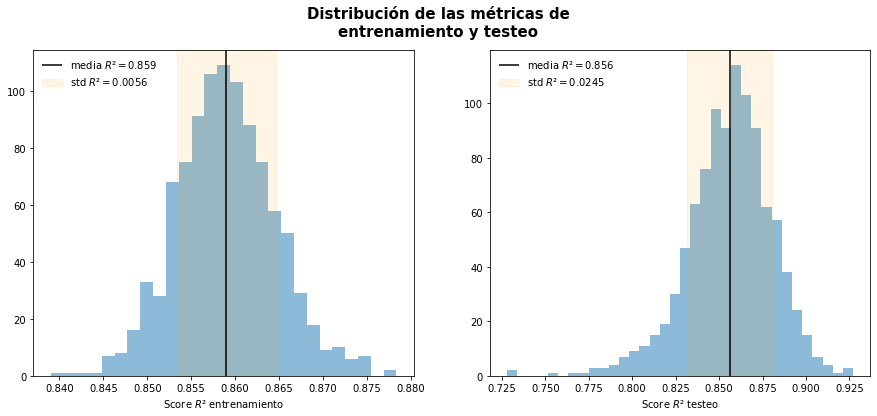

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

# Para las métricas del entrenamiento
ax[0].hist(scores[:,0], 
           bins="fd",
           histtype="bar", alpha=0.5)
ax[0].set_ylim(ax[0].get_ylim()[0], ax[0].get_ylim()[1])
ax[0].vlines(scores[:,0].mean(),
             ymin=ax[0].get_ylim()[0], ymax=ax[0].get_ylim()[1],
             color="k", label=f"media $R² = {round(scores[:,0].mean(),4)}$")
# 1-sigma
ax[0].fill_between(
                x=np.linspace(scores[:,0].mean()-scores[:,0].std(), scores[:,0].mean()+scores[:,0].std(), 100),
                y1=0,
                y2=ax[0].get_ylim()[1],
                alpha=0.1, color="orange", label=f"std $R² = {round(scores[:,0].std(),4)}$"
                   )
ax[0].legend(frameon=False, loc="upper left")
ax[0].set_xlabel("Score $R²$ entrenamiento")


# Para las métricas de testing
ax[1].hist(scores[:,1],
           bins="fd",
           histtype="bar", alpha=0.5)
ax[1].set_ylim(ax[1].get_ylim()[0], ax[1].get_ylim()[1])
ax[1].vlines(scores[:,1].mean(),
             ymin=ax[1].get_ylim()[0], ymax=ax[1].get_ylim()[1],
             color="k", label=f"media $R² = {round(scores[:,1].mean(),4)}$")
# 1-sigma
ax[1].fill_between(
                x=np.linspace(scores[:,1].mean()-scores[:,1].std(), scores[:,1].mean()+scores[:,1].std(), 100),
                y1=0,
                y2=ax[1].get_ylim()[1],
                alpha=0.1, color="orange", label=f"std $R² = {round(scores[:,1].std(),4)}$"
                   )
ax[1].legend(frameon=False, loc="upper left")
ax[1].set_xlabel("Score $R²$ testeo")

fig.suptitle("Distribución de las métricas de\nentrenamiento y testeo", **font)
plt.show()